In [41]:
from scipy import ndimage
import numpy  as np
from scipy.signal import convolve2d
import cv2

In [42]:
def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = convolve2d(img,Kx,mode="same")
    Iy = convolve2d(img,Ky,mode="same")
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (G, theta)

In [43]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

In [44]:

def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09,Tlow= np.int32(25),Tup=np.int32(255)):
    
    highThreshold = img.max() * highThresholdRatio
    lowThreshold = highThreshold * lowThresholdRatio
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = Tlow
    strong = Tup
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)


In [60]:
255*0.5

127.5

In [45]:
def hysteresis(img, weak, strong=255):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

In [65]:
def Canny(img,thresholdLow,thresholdHigh):
    img=ndimage.gaussian_filter(img,1)
    G,theta=sobel_filters(img)
    img=non_max_suppression(G,theta)
    res,weak,strong=threshold(img,lowThresholdRatio=thresholdLow,highThresholdRatio=thresholdHigh)
    img_final=hysteresis(res,weak,thresholdHigh)
    return img_final

# a) Đọc ảnh màu ‘lena.jpg’ và chuyển sang ảnh xám

In [47]:
img=cv2.imread("lena (1).jpg",0)

# b) Áp dụng bộ lọc Canny (Dùng hàm tự viết ở bài 3) để phát hiện biên với 3 bộ ngưỡng khác nhau và đánh giá kết quả

In [66]:
canny1=Canny(img,0.1,0.3)
canny2=Canny(img,0.04,0.07)
canny3=Canny(img,0.2,0.5)

In [49]:
import matplotlib.pyplot as plt

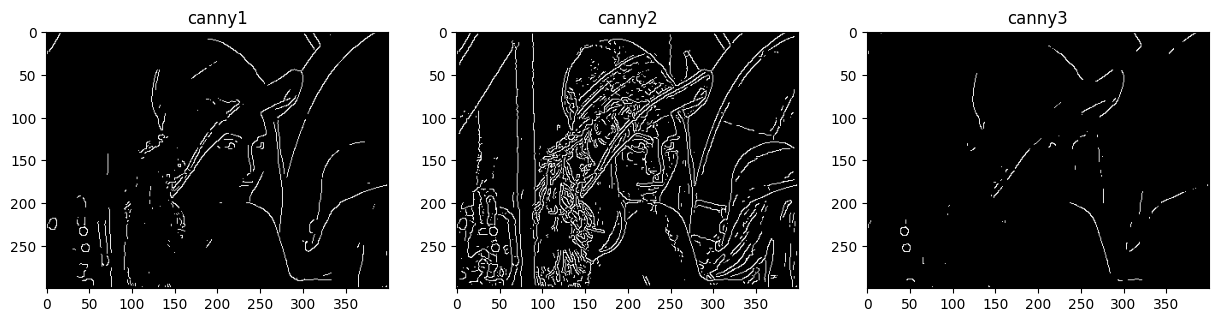

In [67]:
plt.figure(figsize=(15,10))
plt.subplot(131)
plt.title("canny1")
plt.imshow(canny1,"gray")
plt.subplot(132)
plt.title("canny2")
plt.imshow(canny2,"gray")
plt.subplot(133)
plt.title("canny3")
plt.imshow(canny3,"gray")

# đánh giá : ngưỡng đầu tiên chỉ giữ lại được các cạnh thật sự mạnh trong ảnh , ngưỡng thứ 2 giữ lại được hầu hết tất cả các cạnh , ngưỡng thứ 3 loại bỏ hầu hết tất cả các cạnh.

# c) So sánh kết quả của Canny với sobel, đưa ra giải thích

## Sobel:
## Kết quả của Sobel là một bản đồ biên cạnh với các đường viền dày hơn và ít chi tiết hơn.
## Phương pháp Sobel thường phát hiện các biên đơn giản và thiếu chính xác hơn trong các khu vực có nhiễu hoặc chi tiết nhỏ.
## Không có bước lọc nhiễu, vì vậy các chi tiết nhỏ và nhiễu có thể dễ dàng làm sai lệch kết quả biên cạnh.

## Canny:
## Kết quả của Canny sắc nét hơn và có khả năng phát hiện biên tốt hơn, bao gồm cả các biên mảnh và chi tiết nhỏ.
## Các đường viền trong Canny thường mảnh hơn và rõ ràng hơn nhờ vào quá trình làm mịn ảnh và sử dụng ngưỡng kép.
## Phương pháp Canny cũng loại bỏ nhiễu tốt hơn nhờ sử dụng bộ lọc Gaussian trong bước đầu tiên.